# **Taller 1 - Demanda de ocupación hotelera**

### **Integrantes:**
- María Alejandra Pérez Petro - 201923972
- Daniel Esteban Aguilera Figueroa - 202010592 

# Librerias

Se importan las librerías necesarias para el análisis de los datos.

In [176]:
import numpy as np
import pandas as pd

# visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

# estadisticas
from scipy.stats import chi2_contingency, pearsonr, ttest_ind, f_oneway
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# **1. Entendimiento de los datos**
En esta sección se cargan los datos presentados en el archivo `hotel_bookings_modified.csv`, se revisan las dimensiones y se seleccionan las 5 top caracteresticas a analizar.

Se cargan los datos

In [70]:
hotel_df: pd.DataFrame = pd.read_csv("./data/hotel_bookings_modified.csv")

C:\Users\maril\AppData\Local\Temp\ipykernel_22192\2746181375.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  hotel_df: pd.DataFrame = pd.read_csv("./data/hotel_bookings_modified.csv")


Se revisan las dimensiones del dataset. Este cuenta con 33 columnas y 58895 filas

In [71]:
hotel_df.shape

(58895, 33)

Se listan los atributos (columnas) del dataset y sus tipos

In [72]:
hotel_df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                 float64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

se muestran las primeras filas para entender la estructura de los datos

In [73]:
hotel_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,kids
0,Resort Hotel,0,342,2015.0,July,27,1,0,0,2,...,NaN,NaN,0.0,Transient,0.0,0.0,0.0,Check-Out,2015-07-01,NaN
1,Resort Hotel,0,737,2015.0,July,27,1,0,0,2,...,NaN,NaN,0.0,Transient,0.0,0.0,0.0,Check-Out,2015-07-01,NaN
2,Resort Hotel,0,7,2015.0,July,27,1,0,1,1,...,NaN,NaN,0.0,Transient,75.0,0.0,0.0,Check-Out,2015-07-02,NaN
3,Resort Hotel,0,13,2015.0,July,27,1,0,1,1,...,304.0,NaN,0.0,Transient,75.0,0.0,0.0,Check-Out,2015-07-02,NaN
4,Resort Hotel,0,14,2015.0,July,27,1,0,2,2,...,240.0,NaN,0.0,Transient,98.0,0.0,1.0,Check-Out,2015-07-03,NaN


De igual manera, se hace un profilling general para una mejor revisión de todas las variables

In [74]:
#from ydata_profiling import ProfileReport
#profile = ProfileReport(hotel_df)

In [ ]:
# profile.to_file('data/report.html')

## **Top 5 atributos más importantes para el análisis**

Considerando el contexto del negocio hotelero y los objetivos de análisis (optimización de ocupación, gestión de cancelaciones, políticas de precios) se ha seleccionado los siguientes 5 atributos como los más importantes:

1. `is_canceled` : Variable objetivo principal para entender patrones de cancelación (0 = reserva no cancelada, 1 = reserva cancelada).
2.  `adr`: Tarifa diaria promedio (*Average Daily Rate*) definida como la división de la suma de todas las transacciones de alojamiento por el número total de noches de estadía. Indicador clave de ingresos del hotel y estrategia de precios.
3.  `lead_time`: Número de días transcurridos entre la fecha de la reserva y la fecha de llegada. El tiempo de anticipación de la reserva es crucial para planificación y gestión de demanda.
4.  `hotel`: Tipo de hotel (H1 = Resort vs H2 = City) - segmentación fundamental del negocio
5.  `customer_type`: Tipo de cliente según el origen y naturaleza de su reserva. Esta variable es muy útil para analizar qué segmento de mercado aporta más ocupación y rentabilidad.
    - *Contract*: usualmente son reservas negociadas con empresas, aerolíneas u operadores turísticos que garantizan cierto número de habitaciones. Representan clientes corporativos o de convenios, con ingresos más estables pero tarifas generalmente más bajas.
    - *Group*: se refiere a grupos organizados (ej. convenciones, bodas, excursiones). Suelen implicar varias habitaciones reservadas juntas y pueden influir en la ocupación de manera puntual.
    - *Transient*: son huéspedes que reservan de forma independiente (ej. un turista que reserva por una web o directamente en el hotel). Suelen pagar tarifa estándar o dinámica, y aportan ingresos más altos por habitación.
    - *Transient-party*: son reservas individuales pero vinculadas entre sí (ej. una familia que hace varias reservas separadas pero viajan juntos). Representan un subsegmento híbrido entre individual y grupo pequeño.


## **Análisis Univariado**

### 1. Análisis de `is_canceled` (Variable de cancelación)

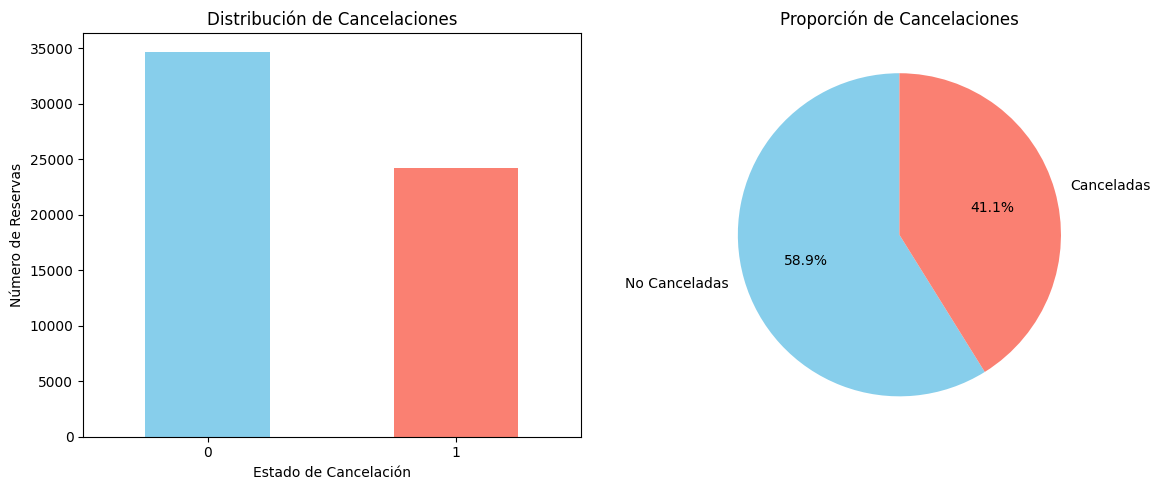

In [76]:
# Distribución de cancelaciones
cancelation_stats = hotel_df['is_canceled'].value_counts()
cancelation_pct = hotel_df['is_canceled'].value_counts(normalize=True) * 100

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras
cancelation_stats.plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Distribución de Cancelaciones')
ax1.set_xlabel('Estado de Cancelación')
ax1.set_ylabel('Número de Reservas')
ax1.tick_params(axis='x', rotation=0)

# Gráfico de pastel
ax2.pie(cancelation_stats.values, labels=['No Canceladas', 'Canceladas'], 
        autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
ax2.set_title('Proporción de Cancelaciones')

plt.tight_layout()
plt.show()


**Análisis univariado de `is_canceled`** 

Se observa que el 41.1% de las reservas fueron canceladas, lo que se traduce en más de 24,000 cancelaciones. Por otro lado, el 58.9% de las reservas se mantuvieron, representando más de 34,000 reservas. Esta alta tasa de cancelación sugiere la necesidad de investigar los factores que la impulsan para poder implementar estrategias que ayuden a reducirlas.

### 2. Análisis de `adr` (Average Daily Rate)

In [77]:
# Estadísticas descriptivas
adr_stats = hotel_df['adr'].describe()
print("Estadísticas descriptivas:")
print(f"Media: ${adr_stats['mean']:.2f}")
print(f"Mediana: ${adr_stats['50%']:.2f}")
print(f"Desviación estándar: ${adr_stats['std']:.2f}")
print(f"Mínimo: ${adr_stats['min']:.2f}")
print(f"Máximo: ${adr_stats['max']:.2f}")
print(f"Q1 (25%): ${adr_stats['25%']:.2f}")
print(f"Q3 (75%): ${adr_stats['75%']:.2f}")


Estadísticas descriptivas:
Media: $96.25
Mediana: $84.00
Desviación estándar: $58.56
Mínimo: $-6.38
Máximo: $5400.00
Q1 (25%): $60.00
Q3 (75%): $120.00


In [78]:
# Filtrar outliers extremos para mejores visualizaciones
Q1 = adr_stats['25%']
Q3 = adr_stats['75%']
IQR = Q3 - Q1
valores_atipicos = (hotel_df['adr'] < Q1 - 1.5 * IQR) | (hotel_df['adr'] > Q3 + 1.5 * IQR)
adr_filtered = hotel_df[~valores_atipicos]
print(f"Número de outliers eliminados: {valores_atipicos.sum()}, {valores_atipicos.sum() / len(hotel_df) * 100:.2f}% del total")

Número de outliers eliminados: 2721, 4.62% del total


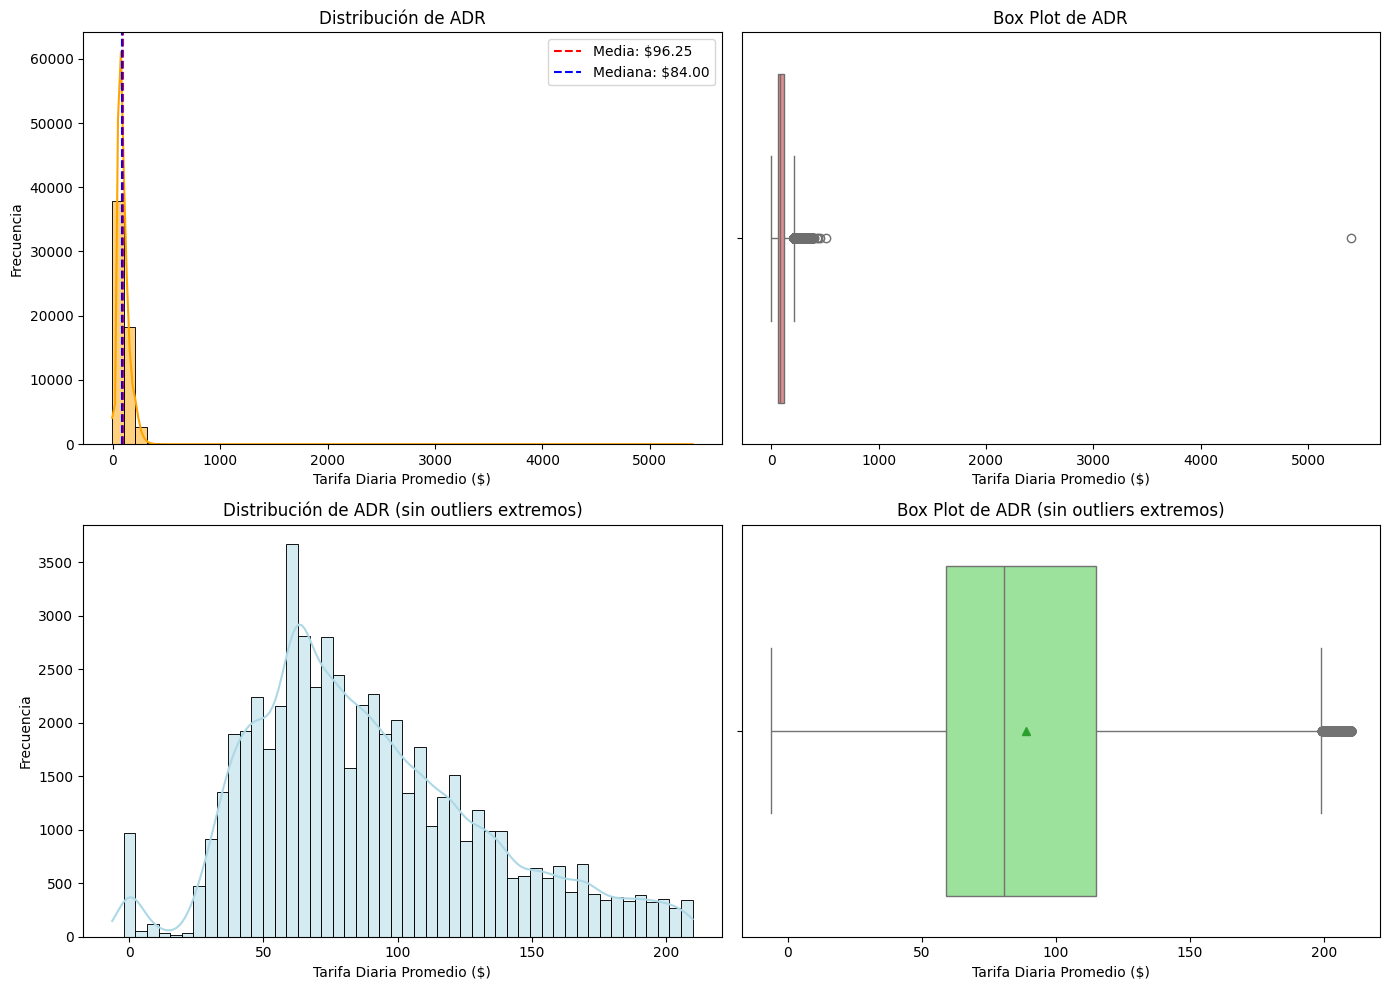

In [79]:
# Subplots 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma completo con KDE
sns.histplot(hotel_df['adr'], bins=50, kde=True, ax=axes[0, 0], color='orange')
axes[0, 0].set_title('Distribución de ADR')
axes[0, 0].set_xlabel('Tarifa Diaria Promedio ($)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].axvline(adr_stats['mean'], color='red', linestyle='--', label=f'Media: ${adr_stats["mean"]:.2f}')
axes[0, 0].axvline(adr_stats['50%'], color='blue', linestyle='--', label=f'Mediana: ${adr_stats["50%"]:.2f}')
axes[0, 0].legend()

# Boxplot completo
sns.boxplot(x=hotel_df['adr'], ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Box Plot de ADR')
axes[0, 1].set_xlabel('Tarifa Diaria Promedio ($)')

# Histograma sin outliers con KDE
sns.histplot(adr_filtered['adr'], bins=50, kde=True, ax=axes[1, 0], color='lightblue')
axes[1, 0].set_title('Distribución de ADR (sin outliers extremos)')
axes[1, 0].set_xlabel('Tarifa Diaria Promedio ($)')
axes[1, 0].set_ylabel('Frecuencia')

# Boxplot sin outliers
sns.boxplot(x=adr_filtered['adr'], ax=axes[1, 1], color='lightgreen', showmeans=True)
axes[1, 1].set_title('Box Plot de ADR (sin outliers extremos)')
axes[1, 1].set_xlabel('Tarifa Diaria Promedio ($)')

plt.tight_layout()
plt.show()

**Análisis univariado de `adr` (Average Daily Rate)**
- Se observa un valor mínimo negativo (-$6.38), el cual resulta inconsistente con la naturaleza de la variable. Por lo que se asume que corresponde a un error o registro anómalo.
- El valor máximo ($5400.00) constituye un caso atípico extremo, muy alejado del rango intercuartílico, que distorsiona la escala de representación gráfica.
- La eliminación de outliers extremos permite visualizar con mayor claridad la estructura real de la distribución.
- El 50 % de las reservas se concentra entre $60.00 (Q1) y $120.00 (Q3), lo que constituye el rango intercuartílico de mayor relevancia para el análisis.
- Los histogramas muestran que la mayoría de las observaciones se ubican en un rango relativamente bajo (aproximadamente por debajo de $150), lo que sugiere que los precios extremos son poco frecuentes, aunque influyen en las medidas de tendencia central.
- La desviación estándar de $58.56 revela una variabilidad considerable en las tarifas, lo que refleja la coexistencia de distintos segmentos de precios dentro de la muestra.


### 3. Análisis de `lead_time` (Tiempo de anticipación)

In [80]:
# Estadísticas descriptivas
lead_time_stats = hotel_df['lead_time'].describe()
print("Estadísticas descriptivas:")
print(f"Media: {lead_time_stats['mean']:.2f} días")
print(f"Mediana: {lead_time_stats['50%']:.2f} días")
print(f"Desviación estándar: {lead_time_stats['std']:.2f} días")
print(f"Mínimo: {lead_time_stats['min']:.0f} días")
print(f"Máximo: {lead_time_stats['max']:.0f} días")
print(f"Q1 (25%): {lead_time_stats['25%']:.2f} días")
print(f"Q3 (75%): {lead_time_stats['75%']:.2f} días")

Estadísticas descriptivas:
Media: 100.05 días
Mediana: 69.00 días
Desviación estándar: 101.16 días
Mínimo: 0 días
Máximo: 737 días
Q1 (25%): 17.00 días
Q3 (75%): 157.00 días


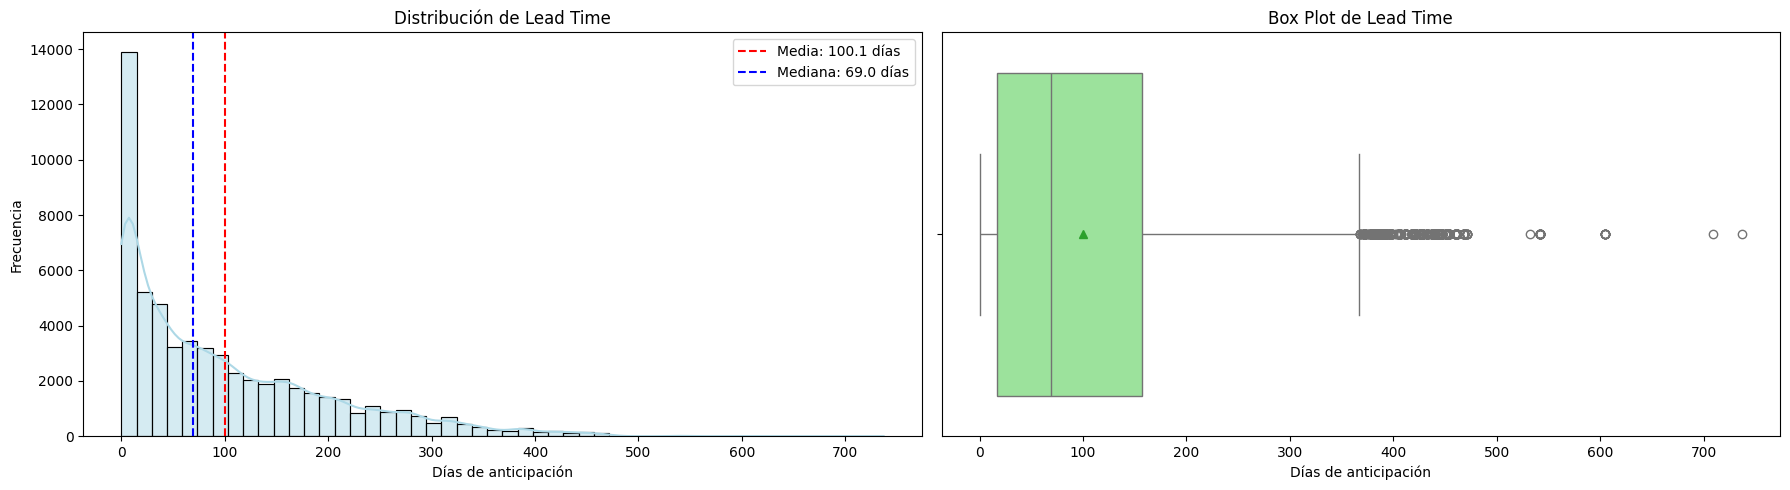

In [81]:
# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# Histograma con KDE
sns.histplot(x = hotel_df['lead_time'], bins=50, kde=True, ax=ax1, color='lightblue')
ax1.set_title('Distribución de Lead Time')
ax1.set_xlabel('Días de anticipación')
ax1.set_ylabel('Frecuencia')
ax1.axvline(lead_time_stats['mean'], color='red', linestyle='--', label=f'Media: {lead_time_stats["mean"]:.1f} días')
ax1.axvline(lead_time_stats['50%'], color='blue', linestyle='--', label=f'Mediana: {lead_time_stats["50%"]:.1f} días')
ax1.legend()

# Boxplot horizontal
sns.boxplot(x=hotel_df['lead_time'], ax=ax2, color='lightgreen', showmeans=True)
ax2.set_title('Box Plot de Lead Time')
ax2.set_xlabel('Días de anticipación')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

- El análisis del `lead_time` muestra una distribución de datos sesgada hacia la derecha. La media (100 días) es significativamente mayor que la mediana (69 días), lo que refuerza el sesgo positivo. Esto indica que aunque la mayoría de los clientes reservan con poca anticipación, unos pocos hacen reservas con mucho tiempo de antelación, aumentando la media.

-  El `lead_time` varía desde un **mínimo de 0 días** (reservas del mismo día) hasta un **máximo de 737 días** (aproximadamente dos años). Esto muestra un rango de planificación muy amplio. La desviación estándar de 101.16 días es alta, lo que indica una gran variabilidad en los datos. Esto refuerza la idea de que los tiempos de anticipación son muy dispersos, no agrupados alrededor de un solo valor.

In [82]:
# Categorización del lead time
def categorize_lead_time(days):
    if days == 0:
        return 'Mismo día'
    elif days <= 7:
        return '1 semana'
    elif days <= 30:
        return '1 mes'
    elif days <= 90:
        return '3 meses'
    elif days <= 180:
        return '6 meses'
    else:
        return 'Más de 6 meses'

In [83]:
hotel_df['lead_time_categorical'] = hotel_df['lead_time'].apply(categorize_lead_time)
lead_time_categories = hotel_df['lead_time_categorical'].value_counts()

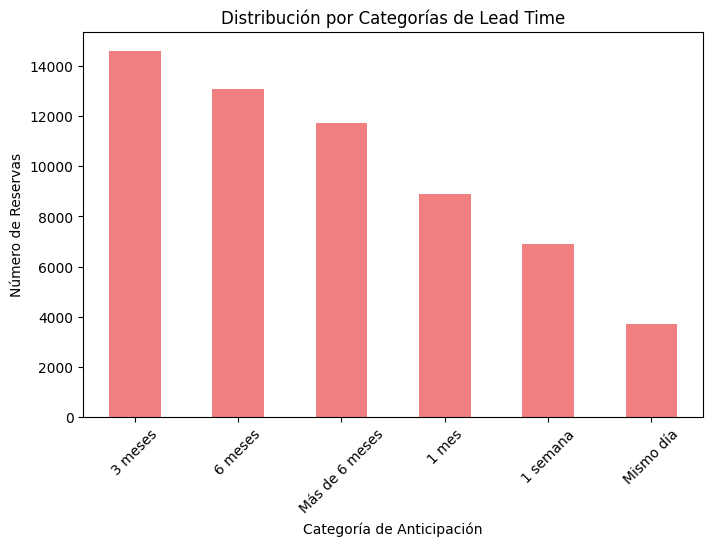

In [84]:
# Gráfico de barras independiente
fig, ax = plt.subplots(figsize=(8, 5))

lead_time_categories.plot(kind='bar', ax=ax, color='lightcoral')
ax.set_title('Distribución por Categorías de Lead Time')
ax.set_xlabel('Categoría de Anticipación')
ax.set_ylabel('Número de Reservas')
ax.tick_params(axis='x', rotation=45)


# Limpiar columna temporal
hotel_df.drop('lead_time_categorical', axis=1, inplace=True)


El gráfico de barras muestra la distribución de las reservas por categorías de tiempo de anticipación.

* **Reservas a largo - medio plazo**: La categoría más frecuente son las reservas hechas con **3 meses de anticipación**, con más de 14,000 reservas, seguida por las de **6 meses** y las de **más de 6 meses**. Esto sugiere que una gran parte de los clientes planifica con varios meses de anticipación.
* **Reservas de último minuto**: Las categorías de **1 semana** y **mismo día** tienen el menor número de reservas, aunque siguen siendo significativas. Esto es importante para la gestión de la demanda a corto plazo.



### 4. Análisis de `hotel` (Tipo de hotel)

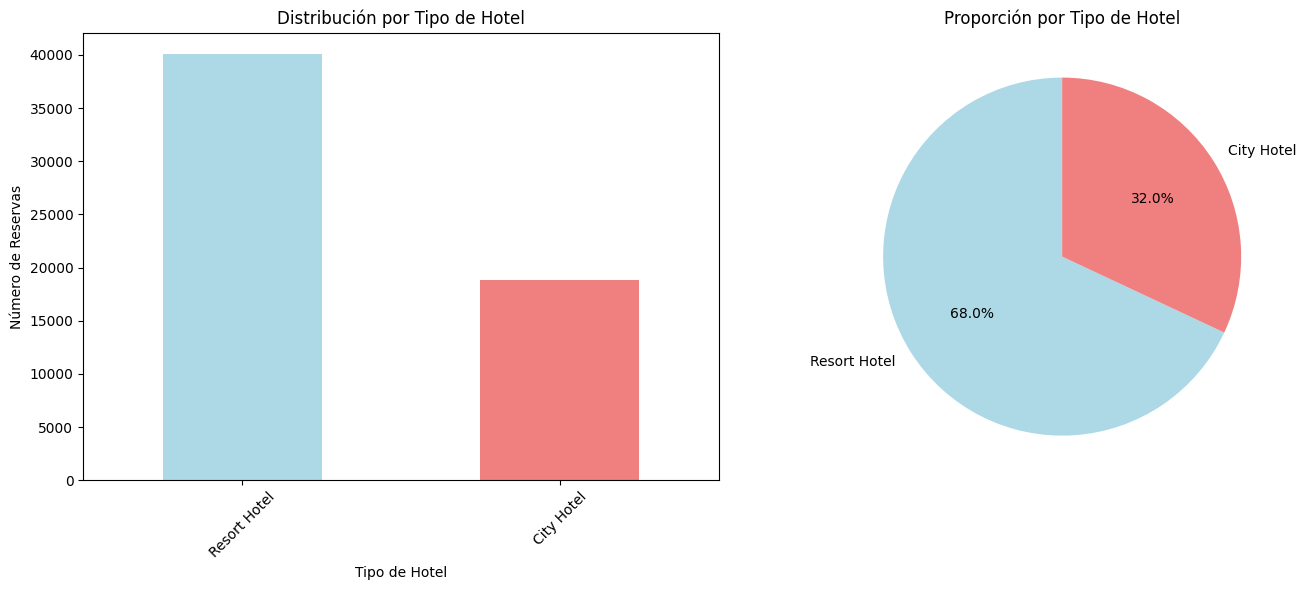

In [85]:
# Distribución por tipo de hotel
hotel_stats = hotel_df['hotel'].value_counts()
hotel_pct = hotel_df['hotel'].value_counts(normalize=True) * 100

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de barras
hotel_stats.plot(kind='bar', ax=ax1, color=['lightblue', 'lightcoral'])
ax1.set_title('Distribución por Tipo de Hotel')
ax1.set_xlabel('Tipo de Hotel')
ax1.set_ylabel('Número de Reservas')
ax1.tick_params(axis='x', rotation=45)

# Gráfico de pastel
ax2.pie(hotel_stats.values, labels=hotel_stats.index, autopct='%1.1f%%', 
        startangle=90, colors=['lightblue', 'lightcoral'])
ax2.set_title('Proporción por Tipo de Hotel')

plt.tight_layout()
plt.show()


**Análisis univariado de `hotel`**

El Resort Hotel concentra alrededor de 40,000 reservas, lo que lo convierte en el tipo de hotel con mayor demanda, mientras que el City Hotel registra cerca de 19,000 reservas, casi la mitad que los resorts. En conjunto, esta diferencia se refleja en la proporción de reservas: un 68% corresponde a Resort Hotels frente a un 32% en City Hotels, lo que evidencia una clara preferencia por los alojamientos de tipo vacacional.

### 5. Análisis de `customer_type` (Tipo de cliente)

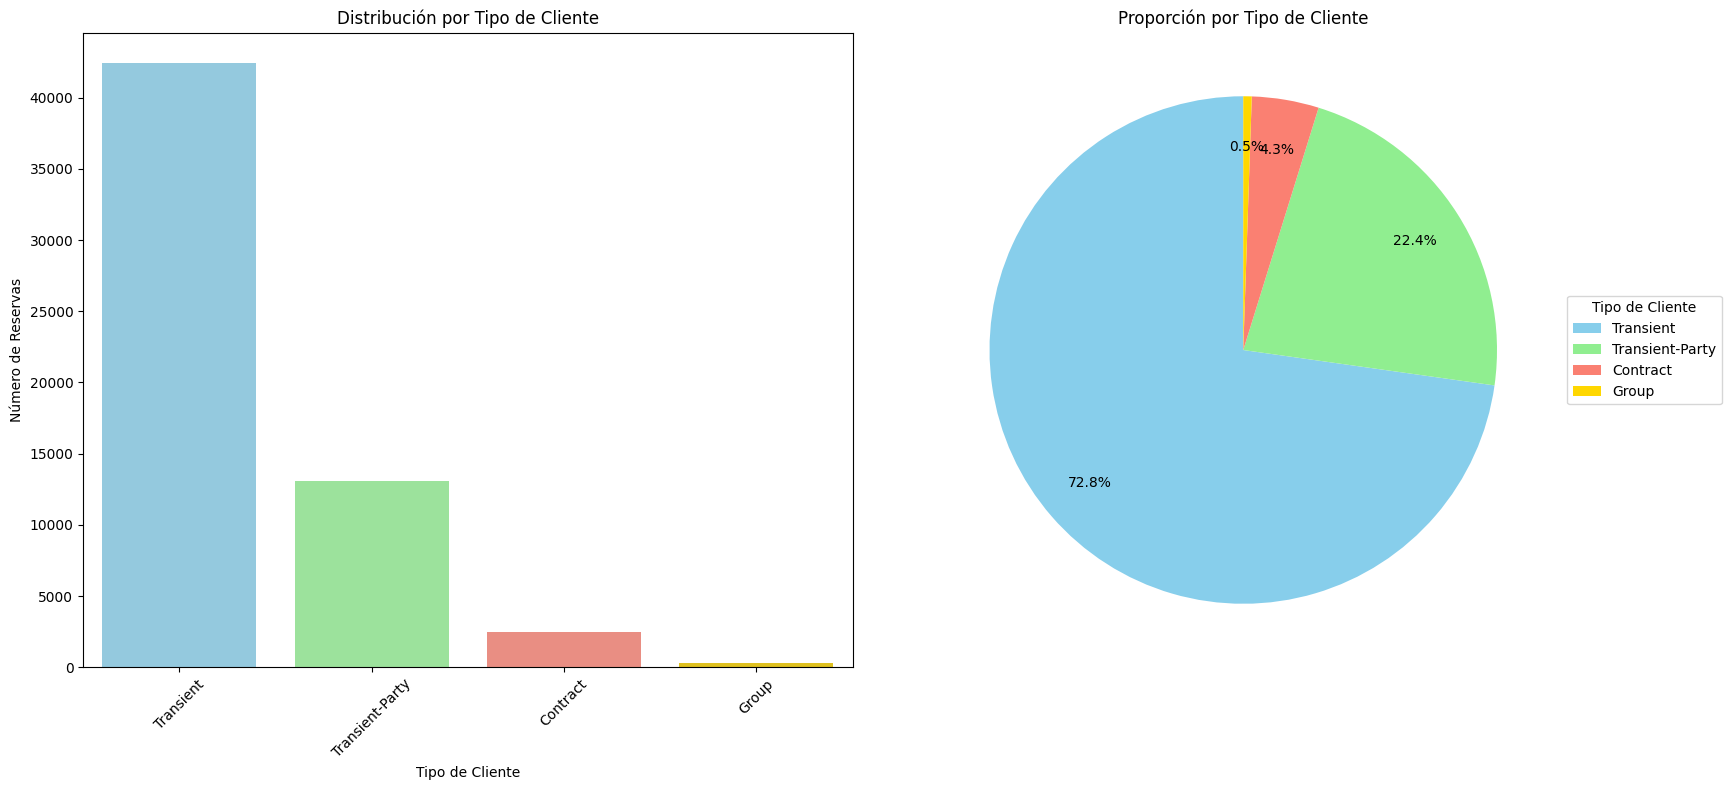

In [86]:
# Datos
customer_stats = hotel_df['customer_type'].value_counts().reset_index()
customer_stats.columns = ['customer_type', 'count']
customer_stats['pct'] = customer_stats['count'] / customer_stats['count'].sum() * 100

# Paleta
palette = ['skyblue', 'lightgreen', 'salmon', 'gold']

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico de barras con Seaborn
sns.barplot(
    data=customer_stats,
    x='customer_type',
    y='count',
    hue='customer_type',
    palette=palette,
    ax=ax1,
    legend=False
)
ax1.set_title('Distribución por Tipo de Cliente')
ax1.set_xlabel('Tipo de Cliente')
ax1.set_ylabel('Número de Reservas')
ax1.tick_params(axis='x', rotation=45)

# Pie chart con leyenda
wedges, texts, autotexts = ax2.pie(
    customer_stats['count'], 
    autopct='%1.1f%%',
    startangle=90,
    colors=palette,
    pctdistance=0.8
)
ax2.set_title('Proporción por Tipo de Cliente')

# Leyenda a la derecha
ax2.legend(
    wedges,
    customer_stats['customer_type'],
    title="Tipo de Cliente",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.tight_layout()
plt.show()


**Análisis univariado de `customer_type`**

El gráfico muestra la distribución y la proporción de reservas según el tipo de cliente (`customer_type`).

* **Transient**: Representa la gran mayoría de las reservas, con un **72.8%** del total.
* **Transient-Party**: Constituye el **22.4%** de las reservas.
* **Contract**: Aportan un **4.3%** del total.
* **Group**: Son una porción mínima, con solo un **0.5%** de las reservas.

En resumen, los datos demuestran una fuerte dependencia de los clientes **Transient** (individuales y en Party) para el volumen total de reservas, mientras que las reservas de grupo y de contrato son una parte muy pequeña del negocio.


# **2. Estrategia de análisis**

La estrategia de análisis se enfocará en estudiar la relación entre la variable objetivo `is_canceled` y los factores seleccionados asociados al comportamiento de las reservas (`adr`, `led_time`, `hotel`, `customer_type`), con el fin de identificar patrones que permitan reducir cancelaciones y mejorar la ocupación hotelera. 

En una primera etapa se calcularán estadísticos descriptivos (medias, medianas, distribuciones y tasas de cancelación) y se aplicarán análisis univariados y multivariados. En una segunda etapa, para el análisis de variables categóricas como `hotel` y `customer_type` se aplicará la prueba de chi-cuadrado, con el fin de evaluar si influyen de manera estadisticamente significativa en la cancelación. Adicionalmente, se empleará correlación de Pearson y pruebas t-student para determinar la relación y diferencias en las medias de `adr` y `lead_time` entre reservas canceladas y no canceladas. El análisis estadistico se acompañará de técnicas de visualización multivariada como histogramas comparativos, boxplots y gráficos de barras segmentados para estudiar combinaciones de variables (ejemplo: tasa de cancelación por tipo de cliente y rango de lead_time). Además, se trabajarán mapas de calor para encontrar las variables con mayor correlación con la variable objetivo. 

Estas herramientas permitirán identificar segmentos de clientes, tipos de hotel y ventanas de reserva donde se concentran mayores cancelaciones o mayores ingresos. Con base en estos hallazgos, será posible formular recomendaciones para mejorar la ocupación y reducir la tasa de cancelación.

# **3. Desarrollo de la estrategia**

En este momento es necesario realizar un tratamiento inicial para hacer un mejor análisis. En primer lugar se revisan distribuciones generales como se hizo anteriormente y que los datos de las variables escogidas correspondan a los mencionados en el diccionario de datos para evitar trabajar con datos que no sean consistentes con las reglas de negocio

In [ ]:
columnas_relevantes = ["adr", "lead_time", "hotel", "customer_type", "is_canceled"]
hotel_df_filtered = hotel_df[columnas_relevantes]

In [103]:
hotel_df_filtered

,adr,lead_time,hotel,customer_type,is_canceled
0,0.00,342,Resort Hotel,Transient,0
1,0.00,737,Resort Hotel,Transient,0
2,75.00,7,Resort Hotel,Transient,0
3,75.00,13,Resort Hotel,Transient,0
4,98.00,14,Resort Hotel,Transient,0
...,...,...,...,...,...
58890,56.00,3,Resort Hotel,Transient-Party,0
58891,83.05,158,Resort Hotel,Transient,1
58892,151.00,18,City Hotel,Transient,1
58893,48.00,383,Resort Hotel,Transient-Party,1


## **3.1 Limpieza y preparación de datos**

En el análisis exploratorio realizado anteriormente (punto 1) se evidencio que:
-  Las variables categóricas (`"hotel", "customer_type", "is_canceled"`) no cuentan con valores fuera de los mostrados en el diccionario. 
-  Las variables numéricas (`"adr", "lead_time"`) podemos observar un comportamiento más variado en sus boxplots, con distribuciones de valores atípicos, como en la variable "adr" la cual cuenta con valores mínimos de $-6.38 y máximos de $5400.

In [106]:
#Revisamos valores nulos
hotel_df_filtered.isna().sum()

adr                1
lead_time          0
hotel              0
customer_type    589
is_canceled        0
dtype: int64

In [120]:
# Revisamos duplicados
num_duplicados = hotel_df_filtered.duplicated().sum()
print(f"Número de duplicados: {num_duplicados} (%{num_duplicados/len(hotel_df_filtered)*100:.2f})")

Número de duplicados: 25366 (%43.07)


Antes de llevar a cabo el análisis multivariado, resulta indispensable realizar un proceso de depuración de los datos con el fin de garantizar la calidad y validez de los resultados. Para ello, se aplicaron los siguientes criterios:

- Se conservarán únicamente las filas que presenten completitud en las cinco columnas de interés.
- No se eliminarán los registros duplicados, dado que en este caso es relevante analizar la frecuencia de las combinaciones y no se trata de un proceso de entrenamiento de modelos predictivos.
- Se eliminarán los valores negativos, así como los atípicos de la variable `adr`, con el propósito de evitar distorsiones en el análisis.

In [110]:
Q1 = adr_stats['25%']
Q3 = adr_stats['75%']
IQR = Q3 - Q1
valores_atipicos = (hotel_df['adr'] < Q1 - 1.5 * IQR) | (hotel_df['adr'] > Q3 + 1.5 * IQR)
valores_negativos = hotel_df['adr'] < 0
print(f"Número de outliers eliminados: {valores_atipicos.sum()}, {valores_atipicos.sum() / len(hotel_df) * 100:.2f}% del total")
print(f"Número de valores negativos eliminados: {valores_negativos.sum()}")

Número de outliers eliminados: 2721, 4.62% del total
Número de valores negativos eliminados: 1


In [114]:
hotel_df_clean = hotel_df_filtered[~valores_atipicos & ~valores_negativos].dropna(subset=columnas_relevantes)

Revisamos las dimensiones finales del dataset que se va a utilizar para el análisis:

In [115]:
hotel_df_clean.shape

(55620, 5)

## **3.2 Análisis de correlaciones**

In [137]:

def calculate_and_plot_correlation_matrix(df_num, method='pearson', mask = False):
    correlation_matrix = df_num.corr(method=method)

    # Crear máscara para ocultar la parte inferior
    mask = None if not mask else np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Heatmap solo parte superior
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={'label': 'Coeficiente de Correlación'})
    plt.title(f'Matriz de Correlación ({method.capitalize()})')
    plt.tight_layout()
    plt.show()

    return correlation_matrix

In [ ]:
# Crear matriz de correlación para variables numéricas
numeric_vars = ['adr', 'lead_time', 'is_canceled']
df_numeric = hotel_df_clean[numeric_vars]

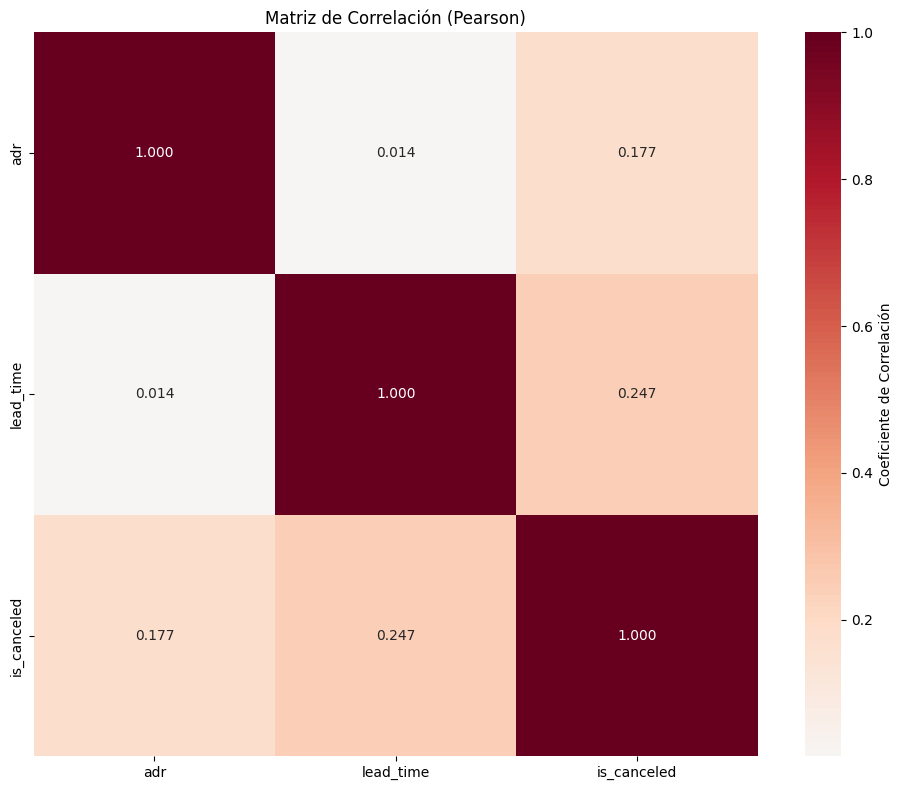

In [ ]:
# Correlacion de Pearson
correlation_matrix = calculate_and_plot_correlation_matrix(df_numeric, method='pearson')

El `lead_time` (0.247) es la variable con mayor asociación con la cancelación de reservas, seguido en menor medida por `adr` (0.177). Aun así, las correlaciones no son lo suficientemente altas como para afirmar una dependencia fuerte, lo que sugiere explorar también patrones no lineales o segmentados (por ejemplo, con correlaciones por rangos o métodos como Spearman). En contraste, `adr` y `lead_time` apenas presentan dependencia lineal entre ellas, actuando como factores prácticamente independientes.

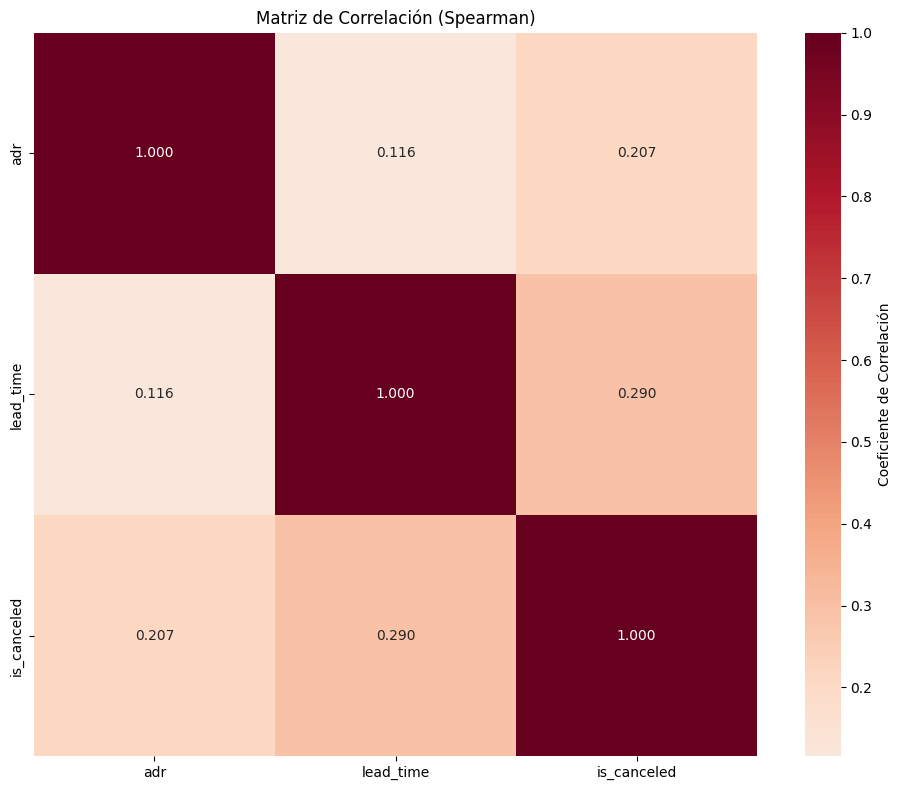

In [ ]:
# Correlacion de Spearman
correlation_matrix = calculate_and_plot_correlation_matrix(df_numeric, method='spearman')


En conjunto, los resultados de correlación muestran que la variable `lead_time` es la que más se relaciona con la cancelación de reservas, seguida en menor medida por `adr`. La comparación entre Pearson y Spearman revela que, aunque existen asociaciones lineales débiles o moderadas, las correlaciones de Spearman son ligeramente más altas, lo que indica la presencia de relaciones no lineales de tipo monótono. Esto significa que, por ejemplo, a mayor anticipación (`lead_time`) o tarifa diaria (`adr`), la probabilidad de cancelación tiende a aumentar, pero no de manera proporcional en toda la distribución. 

## **3.3 Análisis bivariado**

In [ ]:
target_variable = 'is_canceled'
categorical_vars = ["hotel", "customer_type"]
numerical_vars = ["adr", "lead_time"]

**Pruebas estádisticas**

Estas funciones se usaran más adelante para elaborar pruebas estadisticas.

In [186]:
# ========= 1. CHI-CUADRADO (hotel, customer_type vs is_canceled) =========
def chi_square_test(df, cat_var, target='is_canceled'):
    tabla = pd.crosstab(df[cat_var], df[target])
    chi2, p, dof, expected = chi2_contingency(tabla)
    print(f"\nChi-cuadrado para {cat_var} vs {target}")
    print("Chi2:", chi2, " - p-valor:", p)
    if p < 0.05:
        print(f"Rechazamos la hipótesis nula: Hay asociación significativa entre {cat_var} y {target}")
    else:
        print(f"No rechazamos la hipótesis nula: No hay asociación significativa entre {cat_var} y {target}.")
    return chi2, p


# ========= 4. T-TEST (adr y lead_time entre canceladas y no canceladas) =========
def t_test(df, num_var, target='is_canceled'):
    grupo1 = df[df[target]==0][num_var].dropna()
    grupo2 = df[df[target]==1][num_var].dropna()
    t, p = ttest_ind(grupo1, grupo2, equal_var=False)  # Welch’s t-test
    print(f"\nT-test para {num_var} entre reservas canceladas y no canceladas")
    print("t:", t, " - p-valor:", p)
    if p < 0.05:
        print(f"Rechazamos la hipótesis nula: Hay diferencia significativa en {num_var} entre reservas canceladas y no canceladas.")
    else:
        print(f"No rechazamos la hipótesis nula: No hay diferencia significativa en {num_var} entre reservas canceladas y no canceladas.")
    return t, p


### **3.3.1 Relación entre ADR y Cancelaciones**

In [148]:
# Estadísticas descriptivas
adr_stats_by_cancellation = hotel_df_clean.groupby('is_canceled')['adr'].agg(['mean', 'median', 'std', 'count'])
adr_stats_by_cancellation

,mean,median,std,count
is_canceled,,,,
0,82.420892,73.3,43.637887,32747
1,97.958987,93.6,40.946946,22873


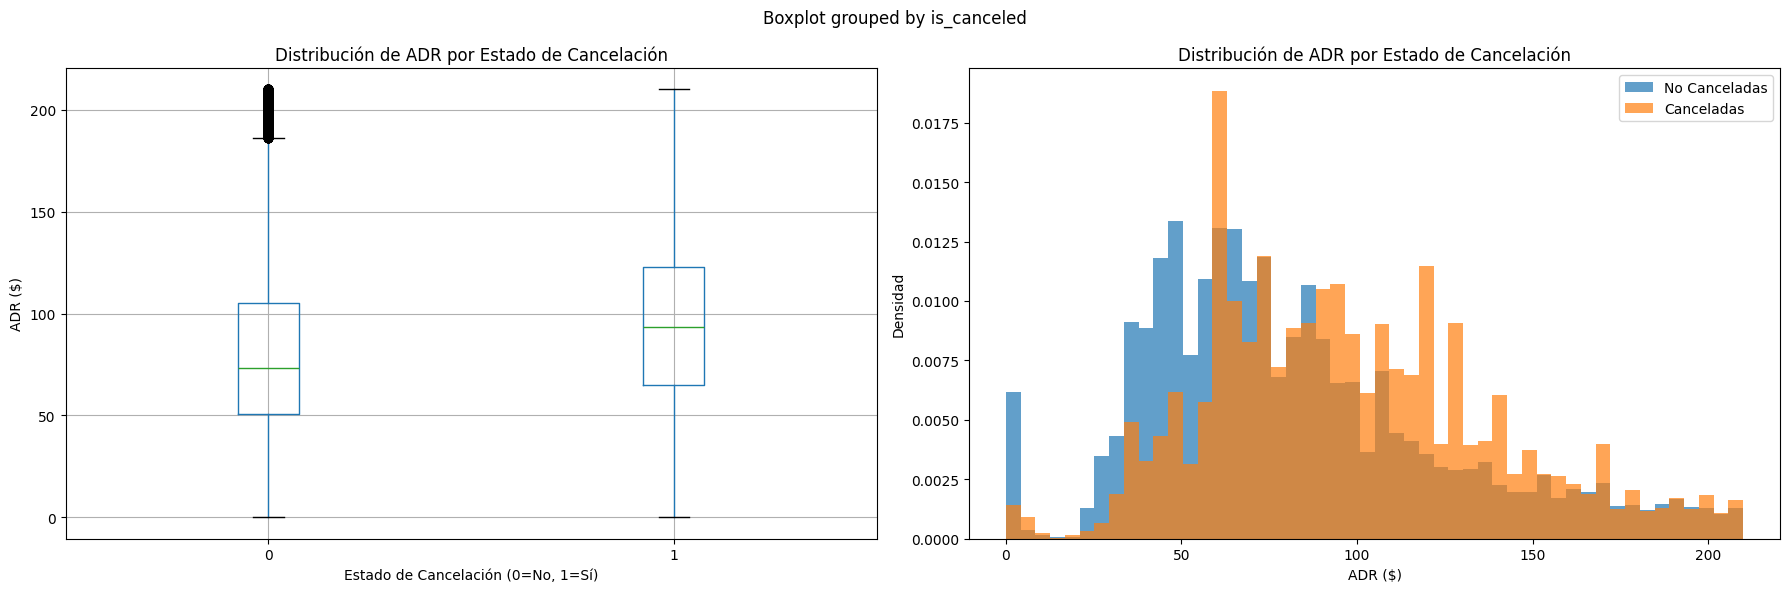

In [ ]:
# Visualizaciones comparativas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Box plot comparativo
hotel_df_clean.boxplot(column='adr', by='is_canceled', ax=ax1)
ax1.set_title('Distribución de ADR por Estado de Cancelación')
ax1.set_xlabel('Estado de Cancelación (0=No, 1=Sí)')
ax1.set_ylabel('ADR ($)')

# Histogramas superpuestos
for canceled in [0, 1]:
    subset = hotel_df_clean[hotel_df_clean['is_canceled'] == canceled]['adr']
    label = 'No Canceladas' if canceled == 0 else 'Canceladas'
    ax2.hist(subset, bins=50, alpha=0.7, label=label, density=True)
ax2.set_title('Distribución de ADR por Estado de Cancelación')
ax2.set_xlabel('ADR ($)')
ax2.set_ylabel('Densidad')
ax2.legend()

plt.tight_layout()
plt.show()

**T-test para ADR: comparacion medias cancelados vs no cancelados**

In [ ]:
t, p = t_test(hotel_df_clean, 'adr')


T-test para adr entre reservas canceladas y no canceladas
t: -42.85600116011506  - p-valor: 0.0


La prueba t-student aplicada a la variable `adr` (Average Daily Rate) evidenció una diferencia estadísticamente significativa entre las reservas canceladas y no canceladas (t = -42.86; p < 0.001). Este resultado indica que las medias de las tarifas diarias difieren de manera consistente entre ambos grupos, lo cual sugiere que el nivel de precios constituye un factor asociado al comportamiento de cancelación.



A continuación, se va a realizar un análisis por rangos de precios en la tarifa promedio diaria (adr), con el fin de identificar en que rangos de precios hay menores tasas de cancelación.

In [171]:
df_temp = hotel_df_clean[["adr", "is_canceled"]].copy()

# Crear intervalos en base a cuartiles
df_temp['adr_range'] = pd.qcut(df_temp['adr'], q=4, duplicates='drop')

# Tasa de cancelación por rango
cancel_rate = (
    df_temp.groupby('adr_range', observed=True)['is_canceled']
    .mean()
    .mul(100)  # convertir a porcentaje directo
    .round(3)
    .reset_index(name='cancel_rate')
)

cancel_rate

,adr_range,cancel_rate
0,"(-0.001, 58.95]",23.071
1,"(58.95, 80.6]",41.953
2,"(80.6, 115.0]",46.787
3,"(115.0, 210.0]",52.878


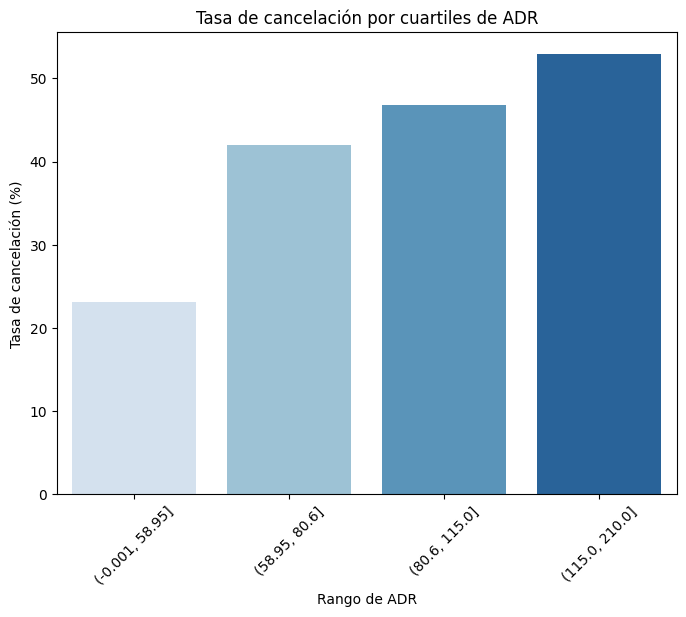

In [170]:


plt.figure(figsize=(8,6))
sns.barplot(
    data=cancel_rate,
    x='adr_range',
    y='cancel_rate',
    palette='Blues',
    hue = "adr_range",
    legend = False

)
plt.ylabel('Tasa de cancelación (%)')
plt.xlabel('Rango de ADR')
plt.title('Tasa de cancelación por cuartiles de ADR')
plt.xticks(rotation=45)
plt.show()


**Test de Anova**

In [173]:
# Dividir los datos en listas por rango de ADR
groups = [df_temp[df_temp['adr_range'] == r]['is_canceled'] for r in df_temp['adr_range'].unique()]
# ANOVA
F, p = f_oneway(*groups)

print("\nANOVA para tasa de cancelación entre rangos de ADR")
print(f"F: {F}, p-valor: {p}")



ANOVA para tasa de cancelación entre rangos de ADR
F: 999.1967874336267, p-valor: 0.0


In [177]:
tukey = pairwise_tukeyhsd(
    endog=df_temp['is_canceled'],   # variable dependiente
    groups=df_temp['adr_range'],    # grupos
    alpha=0.05
)

print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
     group1         group2     meandiff p-adj lower  upper  reject
------------------------------------------------------------------
(-0.001, 58.95]  (58.95, 80.6]   0.1888   0.0 0.1741 0.2036   True
(-0.001, 58.95]  (80.6, 115.0]   0.2372   0.0 0.2225 0.2518   True
(-0.001, 58.95] (115.0, 210.0]   0.2981   0.0 0.2832 0.3129   True
  (58.95, 80.6]  (80.6, 115.0]   0.0483   0.0 0.0336  0.063   True
  (58.95, 80.6] (115.0, 210.0]   0.1093   0.0 0.0944 0.1241   True
  (80.6, 115.0] (115.0, 210.0]   0.0609   0.0 0.0461 0.0757   True
------------------------------------------------------------------


El análisis post-hoc mediante el test de Tukey HSD reveló que todas las comparaciones por pares entre los rangos de precios de ADR mostraron diferencias estadísticamente significativas en la tasa de cancelación (p < 0.001 en todos los casos).


En términos prácticos:

- Clientes con tarifas más bajas (0–59) presentan una tasa de cancelación significativamente menor que todos los demás rangos.

- El rango 59–81 tiene una tasa de cancelación más alta que el rango 0–59, y significativamente más baja que los rangos superiores.

- El rango 81–115 se ubica en un nivel intermedio, pero aun así con una tasa significativamente mayor que los rangos anteriores y menor que el rango más alto.

- El rango más alto (115–210) presenta la mayor tasa de cancelación, significativamente superior a todos los demás.

### **3.3.2 Relación entre `lead_time` y Cancelaciones**

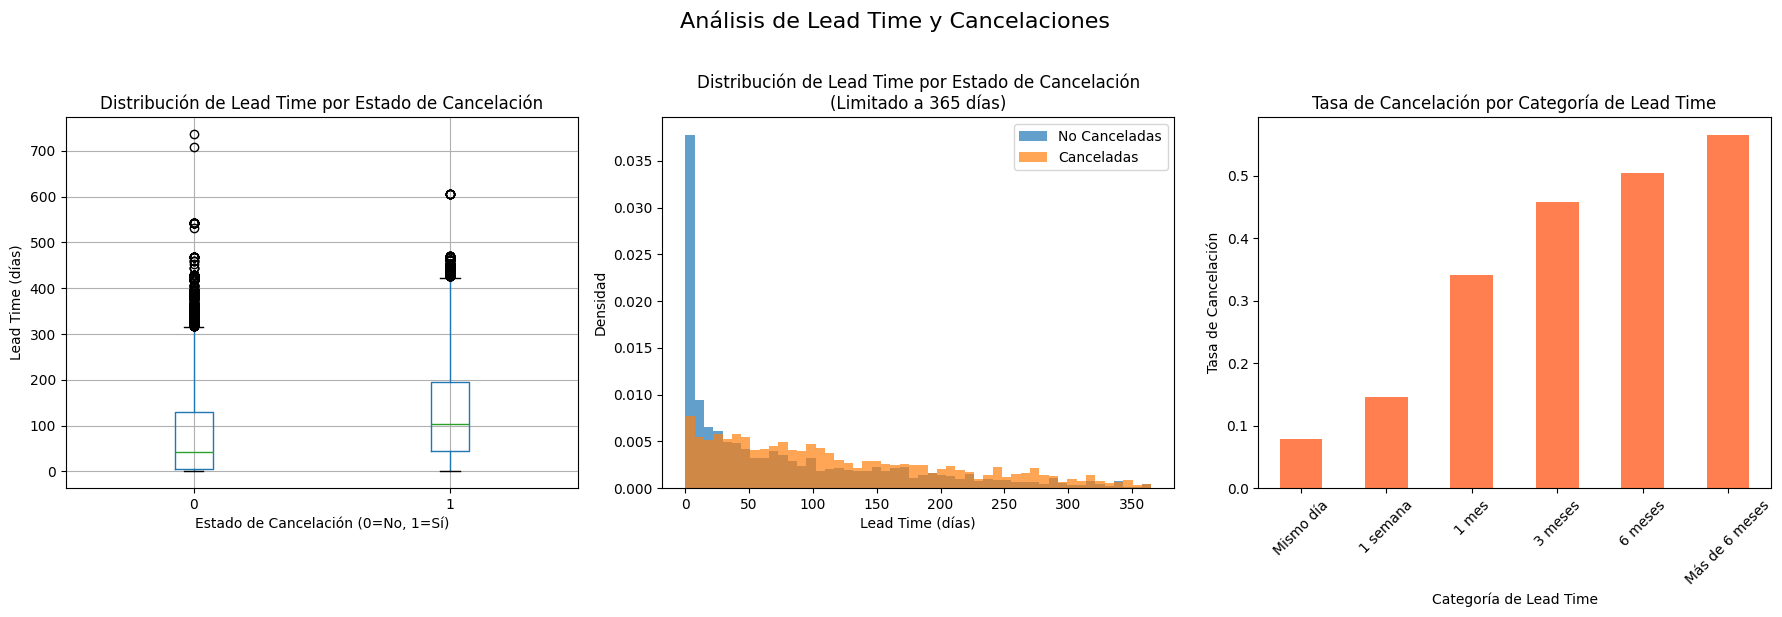

In [180]:
# Análisis de Lead Time por estado de cancelación
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Box plot comparativo
hotel_df_clean.boxplot(column='lead_time', by='is_canceled', ax=ax1)
ax1.set_title('Distribución de Lead Time por Estado de Cancelación')
ax1.set_xlabel('Estado de Cancelación (0=No, 1=Sí)')
ax1.set_ylabel('Lead Time (días)')

# Histogramas superpuestos (limitando a 365 días para mejor visualización)
lead_time_filtered = hotel_df_clean[hotel_df_clean['lead_time'] <= 365]
for canceled in [0, 1]:
    subset = lead_time_filtered[lead_time_filtered['is_canceled'] == canceled]['lead_time']
    label = 'No Canceladas' if canceled == 0 else 'Canceladas'
    ax2.hist(subset, bins=50, alpha=0.7, label=label, density=True)
ax2.set_title('Distribución de Lead Time por Estado de Cancelación\n(Limitado a 365 días)')
ax2.set_xlabel('Lead Time (días)')
ax2.set_ylabel('Densidad')
ax2.legend()

hotel_df_clean['lead_time_category'] = hotel_df_clean['lead_time'].apply(categorize_lead_time)

# Tasa de cancelación por categoría de lead time
cancellation_by_leadtime = hotel_df_clean.groupby('lead_time_category')['is_canceled'].agg(['mean', 'count'])
cancellation_by_leadtime['mean'].sort_values().plot(kind='bar', ax=ax3, color='coral')
ax3.set_title('Tasa de Cancelación por Categoría de Lead Time')
ax3.set_xlabel('Categoría de Lead Time')
ax3.set_ylabel('Tasa de Cancelación')
ax3.tick_params(axis='x', rotation=45)

plt.suptitle('Análisis de Lead Time y Cancelaciones', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

**T-test para `lead_time`: comparacion medias reservas canceladas vs no canceladas**

In [178]:
t, p = t_test(hotel_df_clean, 'lead_time')


T-test para lead_time entre reservas canceladas y no canceladas
t: -58.55832681936453  - p-valor: 0.0


---
La prueba T-test confirma que el **tiempo de anticipación (`lead_time`) es un factor determinante en la decisión de cancelar una reserva**. Las reservas canceladas se realizan, en promedio, con un tiempo de anticipación **significativamente diferente** al de las reservas que se mantienen.


### **3.3.3 Relación entre Tipo de Hotel y Cancelaciones**

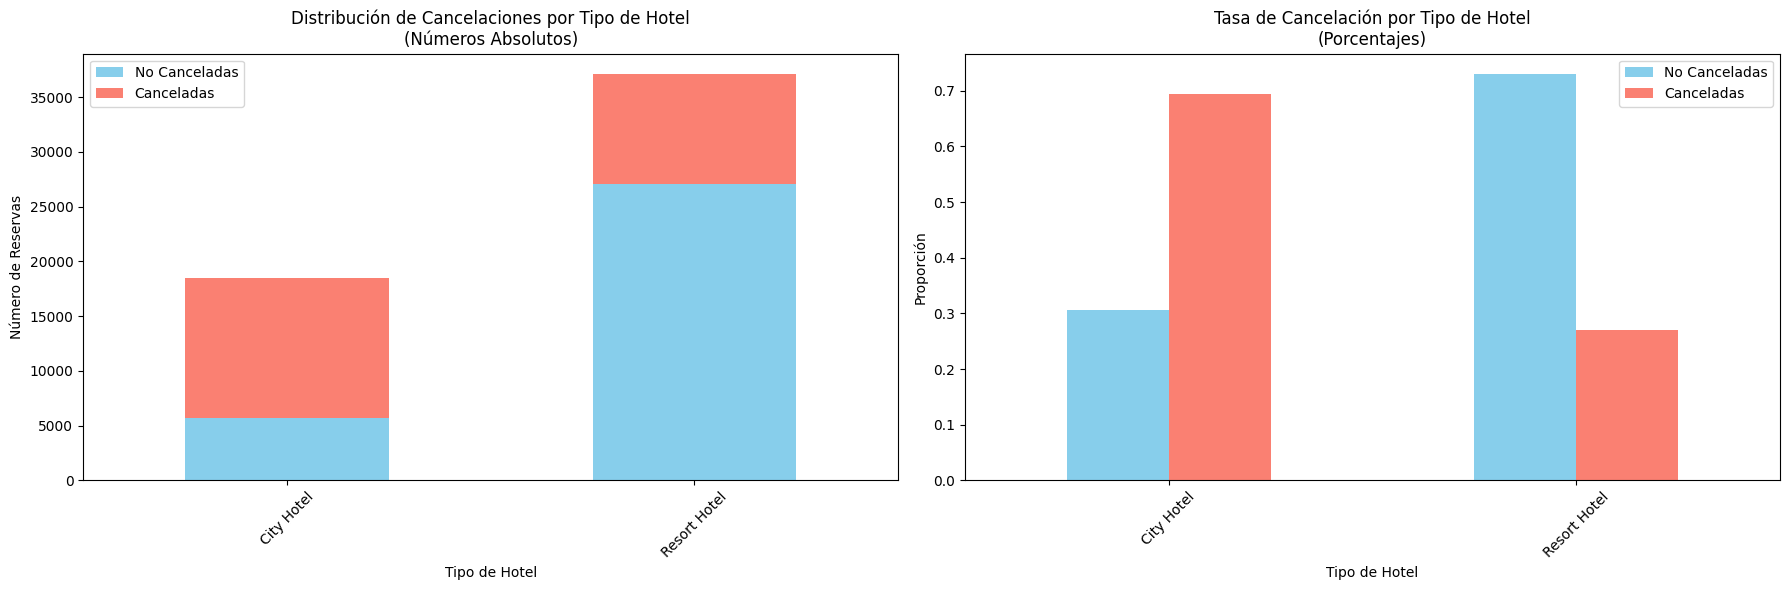

In [185]:
# Análisis de cancelaciones por tipo de hotel
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Tabla cruzada
hotel_cancellation_crosstab = pd.crosstab(hotel_df_clean['hotel'], hotel_df_clean['is_canceled'], normalize='index')

# Gráfico de barras apiladas (números absolutos)
pd.crosstab(hotel_df_clean['hotel'], hotel_df_clean['is_canceled']).plot(kind='bar', 
                                                                         stacked=True, 
                                                                         ax=ax1, 
                                                                         color=['skyblue', 'salmon'])
ax1.set_title('Distribución de Cancelaciones por Tipo de Hotel\n(Números Absolutos)')
ax1.set_xlabel('Tipo de Hotel')
ax1.set_ylabel('Número de Reservas')
ax1.legend(['No Canceladas', 'Canceladas'])
ax1.tick_params(axis='x', rotation=45)

# Gráfico de barras (porcentajes)
hotel_cancellation_crosstab.plot(kind='bar', ax=ax2, color=['skyblue', 'salmon'])
ax2.set_title('Tasa de Cancelación por Tipo de Hotel\n(Porcentajes)')
ax2.set_xlabel('Tipo de Hotel')
ax2.set_ylabel('Proporción')
ax2.legend(['No Canceladas', 'Canceladas'])
ax2.tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

**Test Chi-cuadrado para `hotel` vs `is_canceled`**

In [187]:
chi2, p =chi_square_test(hotel_df_clean, 'hotel')


Chi-cuadrado para hotel vs is_canceled
Chi2: 9205.23843184388  - p-valor: 0.0
Rechazamos la hipótesis nula: Hay asociación significativa entre hotel y is_canceled


---
Los resultados de la prueba de chi-cuadrado indican una asociación estadísticamente significativa entre el tipo de hotel y si una reserva es cancelada o no.

Los gráficos complementan la prueba estadística:
-  La tasa de cancelación en los Hoteles de Ciudad es significativamente más alta, alcanzando casi el 70%. En contraste, la tasa de cancelación en los Hoteles Resort es considerablemente más baja, cerca del 25%.
- En términos de números absolutos, los Hoteles de Ciudad tienen un número mayor de cancelaciones en comparación con los Hoteles Resort, a pesar de que los Resorts tienen un mayor número total de reservas.

### **3.3.4 Relación entre Tipo de Cliente y Cancelaciones**


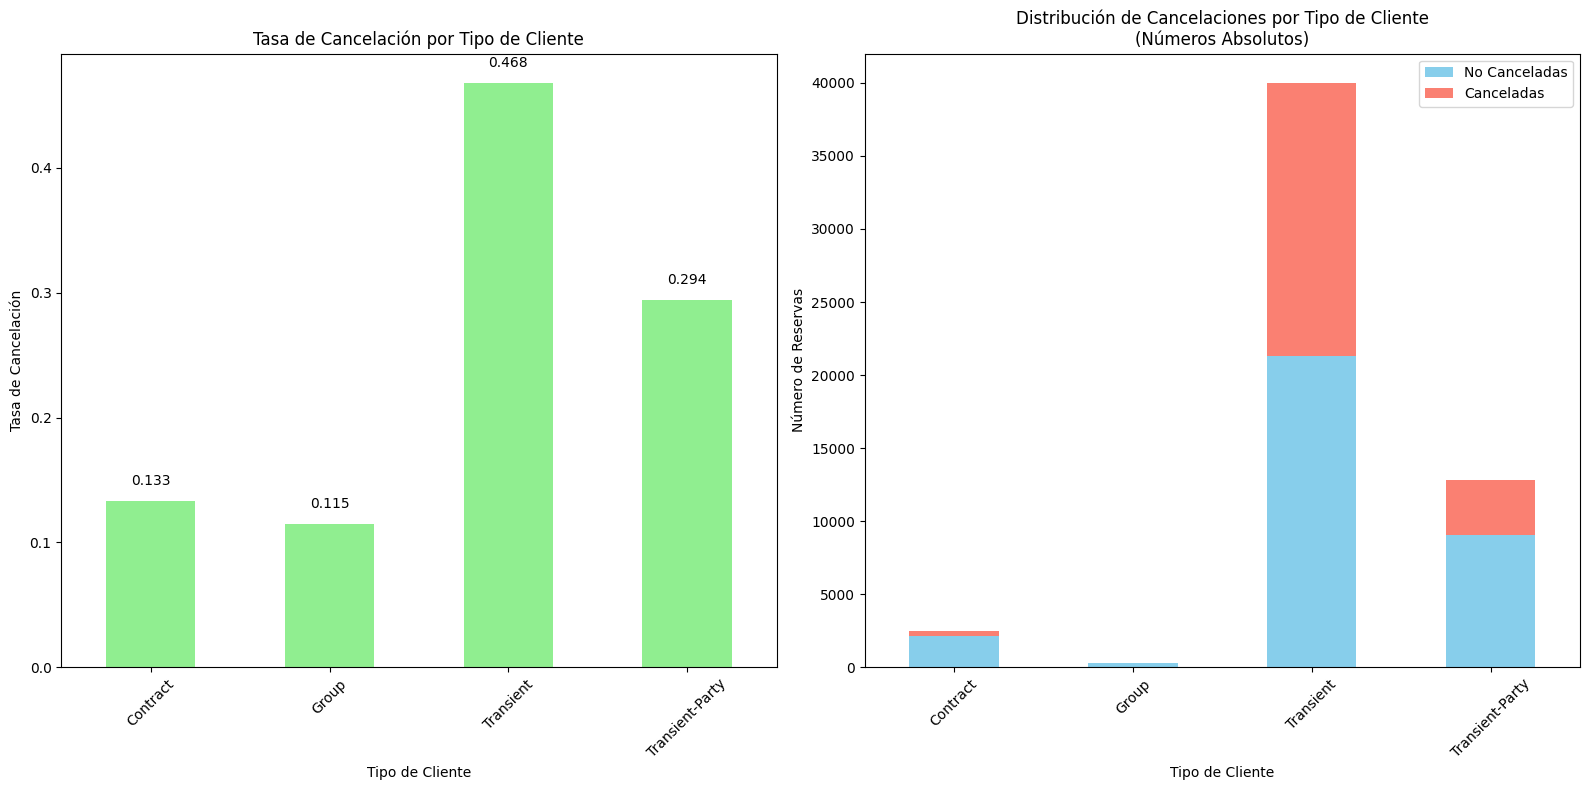

In [196]:
# Análisis de cancelaciones por tipo de cliente
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Tasa de cancelación por tipo de cliente
cancellation_by_customer = hotel_df_clean.groupby('customer_type')['is_canceled'].agg(['mean', 'count'])
cancellation_by_customer['mean'].plot(kind='bar', ax=ax1, color='lightgreen')
ax1.set_title('Tasa de Cancelación por Tipo de Cliente')
ax1.set_xlabel('Tipo de Cliente')
ax1.set_ylabel('Tasa de Cancelación')
ax1.tick_params(axis='x', rotation=45)

# Añadir valores sobre las barras
for i, v in enumerate(cancellation_by_customer['mean']):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Tabla cruzada con porcentajes
customer_cancellation_crosstab = pd.crosstab(hotel_df_clean['customer_type'], 
                                            hotel_df_clean['is_canceled'])
customer_cancellation_crosstab.plot(kind='bar', stacked=True,  ax=ax2, color=['skyblue', 'salmon'])
ax2.set_title('Distribución de Cancelaciones por Tipo de Cliente\n(Números Absolutos)')
ax2.set_xlabel('Tipo de Cliente')
ax2.set_ylabel('Número de Reservas')
ax2.legend(['No Canceladas', 'Canceladas'])
ax2.tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

**Test Chi-cuadrado para `customer_type` vs `is_canceled`**

In [188]:
chi2, p = chi_square_test(hotel_df_clean, 'customer_type')


Chi-cuadrado para customer_type vs is_canceled
Chi2: 2161.5901634097763  - p-valor: 0.0
Rechazamos la hipótesis nula: Hay asociación significativa entre customer_type y is_canceled


---

1. **Diferencias en la tasa de cancelación por tipo de cliente:** En el gráfico de la izquierda se observa que los clientes Transient presentan la tasa de cancelación más alta (46.8%), seguidos de los Transient-Party (29.4%). En contraste, los clientes Contract (13.3%) y especialmente los Group (11.5%) tienen una probabilidad de cancelar mucho menor. Esto indica que los clientes transitorios son los menos confiables en términos de mantener su reserva, mientras que los clientes de grupo o contrato muestran mayor compromiso.

2. **Distribución absoluta de cancelaciones**: El gráfico de la derecha muestra que, en términos absolutos, la mayor cantidad de cancelaciones proviene de los Transient, no solo porque tienen la tasa más alta, sino también porque constituyen el volumen más grande de reservas totales. Los grupos, aunque tienen una tasa muy baja de cancelación, representan un número pequeño de reservas y, por tanto, su impacto en las cancelaciones generales es marginal.

3. **Prueba de independencia Chi-cuadrado:** El test de Chi² arroja un valor de 2161.59 con un p-valor = 0.0, lo que implica que rechazamos la hipótesis nula. En otras palabras, existe una asociación estadísticamente significativa entre el tipo de cliente y la probabilidad de cancelación. No se trata de una relación aleatoria: el tipo de cliente influye de manera real en la decisión de cancelar o no.

# **3.4 Análisis Multivariado**

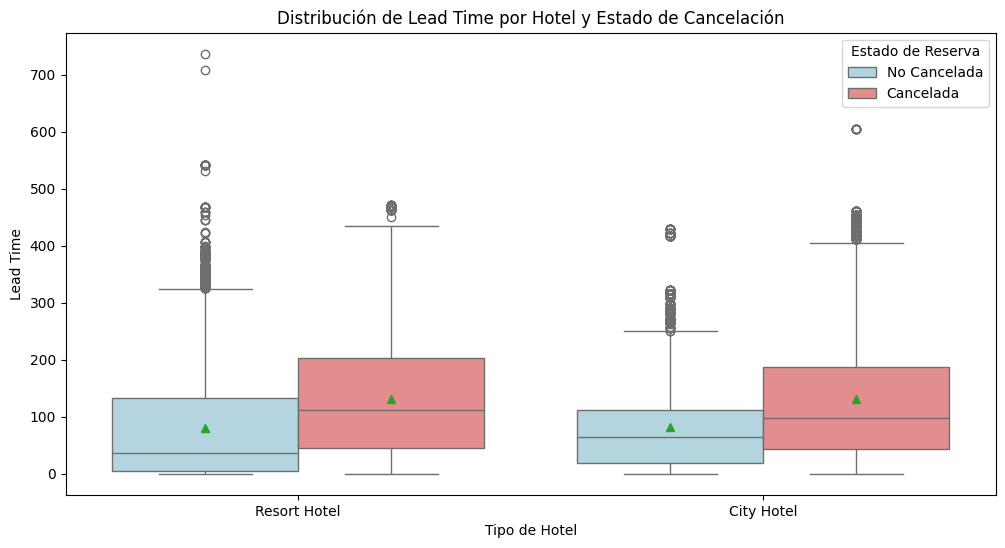

In [224]:
# 2) Paleta como diccionario para garantizar correspondencia color-categoría
pal = {0: 'lightblue', 1: 'lightcoral'}
plt.figure(figsize=(12,6))
sns.boxplot(x='hotel', y='lead_time', hue='is_canceled',
            data=hotel_df_clean, palette=pal, showmeans=True)
plt.title('Distribución de Lead Time por Hotel y Estado de Cancelación')
plt.xlabel("Tipo de Hotel")
plt.ylabel("Lead Time")
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['No Cancelada', 'Cancelada'], title='Estado de Reserva')
plt.show()




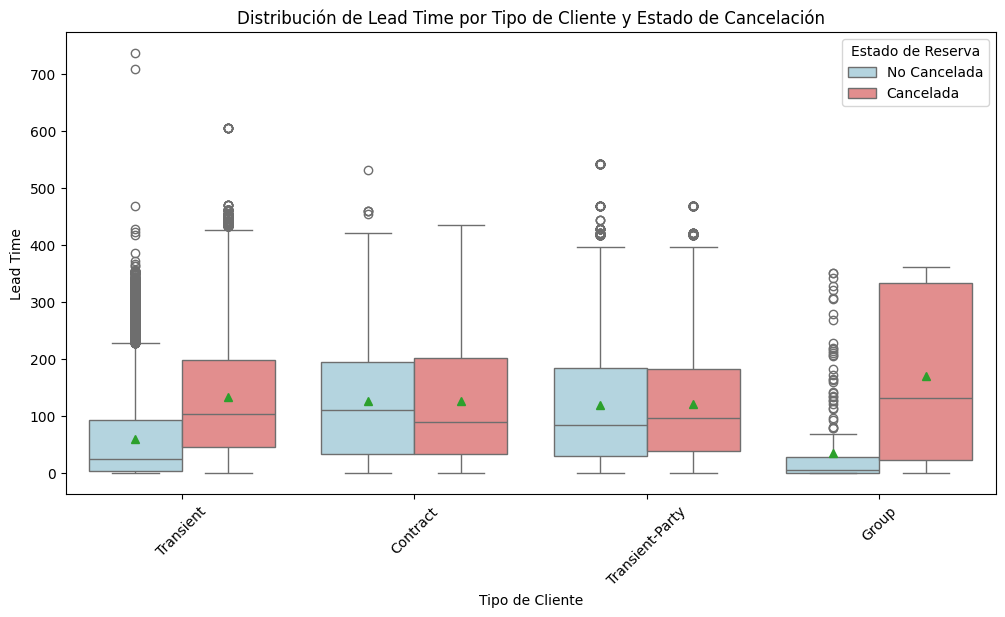

In [223]:
plt.figure(figsize=(12,6))
sns.boxplot(x='customer_type', y='lead_time', hue='is_canceled',
            data=hotel_df_clean,  palette=pal, showmeans=True)
plt.title('Distribución de Lead Time por Tipo de Cliente y Estado de Cancelación')
plt.xlabel("Tipo de Cliente")
plt.ylabel("Lead Time")
plt.xticks(rotation=45)
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['No Cancelada', 'Cancelada'], title='Estado de Reserva')
plt.show()

In [225]:
# ========= 2. ANOVA (adr y lead_time vs hotel, customer_type) =========
def anova_test(df, num_var, cat_var):
    grupos = [df[df[cat_var]==nivel][num_var].dropna() for nivel in df[cat_var].unique()]
    F, p = f_oneway(*grupos)
    print(f"\nANOVA para {num_var} según {cat_var}")
    print("F:", F, " - p-valor:", p)
    return F, p

anova_test(hotel_df_clean, 'adr', 'hotel')
anova_test(hotel_df_clean, 'adr', 'customer_type')
anova_test(hotel_df_clean, 'lead_time', 'hotel')
anova_test(hotel_df_clean, 'lead_time', 'customer_type')


ANOVA para adr según hotel
F: 1177.6777022747522  - p-valor: 2.0463481648721524e-255

ANOVA para adr según customer_type
F: 509.4637699410411  - p-valor: 0.0

ANOVA para lead_time según hotel
F: 611.9104683288723  - p-valor: 2.297317782392533e-134

ANOVA para lead_time según customer_type
F: 283.5288429115639  - p-valor: 1.1472971168841231e-182


(np.float64(283.5288429115639), np.float64(1.1472971168841231e-182))

Tanto en las variables de ingreso (adr) como en las de comportamiento de reserva (lead time), se detectaron diferencias significativas entre hoteles y tipos de clientes. Esto implica que la estrategia de precios y la gestión de reservas no son homogéneas y dependen en gran medida del segmento y del establecimiento.

# Conclusiones

El tipo de cliente es un factor clave para entender y predecir cancelaciones. Los hoteles deberían poner especial atención en las reservas de clientes Transient, ya que concentran tanto la tasa como el volumen absoluto de cancelaciones, lo que los convierte en el segmento de mayor riesgo operativo y financiero.